In [147]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg


def convolve(img, kernel):
    h, w = img.shape
    k_size = kernel.shape[0]
    pad_one_side = (k_size - 1)//2
    h_pad = h + 2*pad_one_side
    w_pad = w + 2*pad_one_side
    
    img_pad = np.zeros((h_pad, w_pad))
    img_pad[pad_one_side : -pad_one_side, pad_one_side : -pad_one_side] = img

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            mat = img_pad[i : i + k_size, j : j + k_size]
            # print("mat = ", mat)
            img[i, j] = np.sum(np.multiply(mat, kernel))
    return img


class Canny:
    def __init__(self, img, threshold1, threshold2, gaussian_sigma=1, gaussian_k_size=5, strong=255, weak=32):
        self.img = img
        self.threshold1 =threshold1
        self.threshold2 = threshold2
        self.gaussian_sigma = gaussian_sigma
        self.gaussian_k_size = gaussian_k_size
        self.strong = strong
        self.weak = weak

    def gaussian_kernel(self, k_size=5, sigma=1):
        tmp = (k_size - 1) / 2
        x, y = np.mgrid[-tmp:tmp+1, -tmp:tmp+1]
        kernel =  1 / (2.0 * np.pi * sigma*sigma) * np.exp(-((x*x + y*y) / (2.0*sigma*sigma)))
        return kernel

    def gaussian_blur(self, img, k_size=5, sigma=1):
        kernel = self.gaussian_kernel(k_size, sigma)
        img_blur = convolve(img, kernel)
        return img_blur

    def sobel_edge(self, img):
        sx = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
        sy = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
        gradient_x = convolve(img, sx)
        gradient_y = convolve(img, sy)
        magnitude = np.hypot(gradient_x, gradient_y)
        magnitude = magnitude / magnitude.max() *255
        # magnitude = magnitude.astype(np.uint8)
        theta = np.arctan2(gradient_y, gradient_x)
        return magnitude, theta

    def non_max_suppression(self, magnitude, theta):
        h, w = magnitude.shape
        output_magnitude = np.zeros(magnitude.shape)
        angle = np.rad2deg(theta)
        angle[angle < 0] += 180
        PI = 180
        for row in range(1, h-1):
            for col in range(1, w-1):
                direction = angle[row, col]
                if (0 <= direction < PI/8) or (7*PI/8 <= direction <= PI):
                    neighbor1 = magnitude[row][col+1]
                    neighbor2 = magnitude[row][col-1]
                elif (PI/8 <= direction < 3*PI/8):
                    neighbor1 = magnitude[row+1][col-1]
                    neighbor2 = magnitude[row-1][col+1]
                elif (3*PI/8 <= direction < 5*PI/8):
                    neighbor1 = magnitude[row+1][col]               
                    neighbor2 = magnitude[row-1][col]
                elif (5*PI/8 <= direction < 7*PI/8):               
                    neighbor1 = magnitude[row-1][col-1]               
                    neighbor2 = magnitude[row+1][col+1]               
                
                if magnitude[row, col] > neighbor1 and magnitude[row, col] > neighbor2:
                    output_magnitude[row, col] = magnitude[row, col]
                    
        return output_magnitude
    
    def hysteresis_thresholding(self, magnitude):
        h, w = magnitude.shape
        output = np.zeros(magnitude.shape)

        high_threshold = magnitude.max() * self.threshold1
        low_threshold = high_threshold * self.threshold2

        strong_row, strong_col = np.where(high_threshold < magnitude)
        weak_row, weak_col = np.where((low_threshold < magnitude) & (magnitude <= high_threshold))
        output[strong_row, strong_col] = self.strong
        output[weak_row, weak_col] = self.weak

        top2bottom = output.copy()
        for row in range(1, h-1):
            for col in range(1, w-1):
                if top2bottom[row][col] == self.weak:
                    if top2bottom[row+1][col+1] ==self.strong or top2bottom[row+1][col] ==self.strong or top2bottom[row+1][col-1] ==self.strong or top2bottom[row][col+1] ==self.strong or top2bottom[row][col-1] ==self.strong or top2bottom[row-1][col+1] ==self.strong or top2bottom[row-1][col] ==self.strong or top2bottom[row-1][col-1] ==self.strong:
                        top2bottom[row, col] = self.strong
                    else:
                        top2bottom[row, col] = 0

        bottom2top = output.copy()
        for row in range(h-2, 0, -1):
            for col in range(w-2, 0, -1):
                if bottom2top[row][col] == self.weak:
                    if bottom2top[row+1][col+1] ==self.strong or bottom2top[row+1][col] ==self.strong or bottom2top[row+1][col-1] ==self.strong or bottom2top[row][col+1] ==self.strong or bottom2top[row][col-1] ==self.strong or bottom2top[row-1][col+1] ==self.strong or bottom2top[row-1][col] ==self.strong or bottom2top[row-1][col-1] ==self.strong:
                        bottom2top[row, col] = self.strong
                    else:
                        bottom2top[row, col] = 0

        right2left = output.copy()
        for row in range(1, h-1):
            for col in range(w-2, 0, -1):
                if right2left[row][col] == self.weak:
                    if right2left[row+1][col+1] ==self.strong or right2left[row+1][col] ==self.strong or right2left[row+1][col-1] ==self.strong or right2left[row][col+1] ==self.strong or right2left[row][col-1] ==self.strong or right2left[row-1][col+1] ==self.strong or right2left[row-1][col] ==self.strong or right2left[row-1][col-1] ==self.strong:
                        right2left[row, col] = self.strong
                    else:
                        right2left[row, col] = 0

        left2right = output.copy()
        for row in range(h-2, 0, -1):
            for col in range(1, w-1):
                if left2right[row][col] == self.weak:
                    if left2right[row+1][col+1] ==self.strong or left2right[row+1][col] ==self.strong or left2right[row+1][col-1] ==self.strong or left2right[row][col+1] ==self.strong or left2right[row][col-1] ==self.strong or left2right[row-1][col+1] ==self.strong or left2right[row-1][col] ==self.strong or left2right[row-1][col-1] ==self.strong:
                        left2right[row, col] = self.strong
                    else:
                        left2right[row, col] = 0
        sum_results = top2bottom + bottom2top + right2left + left2right
        sum_results[sum_results > 255] = 255
        return sum_results

    def threshold(self, img):

        highThreshold = img.max() * self.threshold1
        lowThreshold = highThreshold * self.threshold2

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak)
        strong = np.int32(self.strong)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak
        strong = self.strong

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img

    def detect_edge(self):
        # output_lst = []

        # img_blur = self.gaussian_blur(self.img, self.gaussian_k_size, self.gaussian_sigma)
        # plt.imshow(img_blur, cmap="gray")
        magnitude, theta = self.sobel_edge(self.img)
        # plt.imshow(magnitude, cmap="gray")
        magnitude_nms = self.non_max_suppression(magnitude, theta)
        # plt.imshow(magnitude_nms, cmap="gray")

        output = self.hysteresis_thresholding(magnitude_nms)
        plt.imshow(output, cmap="gray")
        return output


        

(1000, 1200)


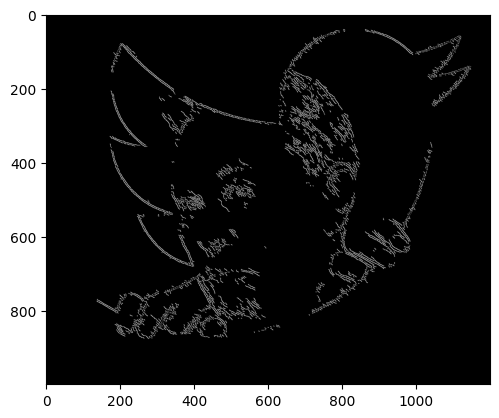

In [148]:
img = mpimg.imread("data/musk2.jpg")
r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
gray = 0.3 * r + 0.59 * g + 0.11 * b
# gray = (r + g +b)/3
print(gray.shape)

canny = Canny(gray, threshold1= 0.15, threshold2= 0.05, gaussian_sigma=5, gaussian_k_size=9 )
output = canny.detect_edge()
# print(type(output[0][0]))
# magnitude_nms = canny.non_max_suppression(output, theta)
# plt.imshow(output, cmap="gray")

In [160]:
import cv2
img = cv2.imread("data/musk2.jpg")
print(img.shape)
img = cv2.resize(img, (600, 500))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, ksize= (5, 5), sigmaX=1)
output = cv2.Canny(blur, 200,100)
cv2.imwrite("output.jpg", output)
cv2.imshow("img", output)
cv2.waitKey(0)

(1000, 1200, 3)


-1